In [748]:
from datasets import load_dataset, Dataset, concatenate_datasets

from datetime import date, datetime
import pandas as pd
import numpy as np

from gluonts.dataset.common import ListDataset


In [749]:
dataset = load_dataset('dataset/index', data_files='GSPC.csv')

filtered_dataset = dataset['train'].filter(lambda e: date.fromisoformat(e['Date'][:10]) > date(2010, 1, 1))
filtered_dataset = filtered_dataset.filter(lambda e: date.fromisoformat(e['Date'][:10]) < date(2011, 1, 1))
train_dataset = filtered_dataset

train_dataset


Using custom data configuration index-c202ce2a383faf27
Found cached dataset csv (/Users/lucyxu/.cache/huggingface/datasets/csv/index-c202ce2a383faf27/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /Users/lucyxu/.cache/huggingface/datasets/csv/index-c202ce2a383faf27/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-f3948e24551e500c.arrow
Loading cached processed dataset at /Users/lucyxu/.cache/huggingface/datasets/csv/index-c202ce2a383faf27/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-bff35835c0a49bf5.arrow


Dataset({
    features: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'],
    num_rows: 252
})

In [750]:
df = pd.read_csv('dataset/index/GSPC.csv', date_parser=True)

df['Date'] = pd.to_datetime(df['Date'], utc=True)
df['Date'] = df['Date'].dt.date

df = df[df['Date'] >= date.fromisoformat('2010-01-01')]
df = df[df['Date'] < date.fromisoformat('2011-01-01')]

missing_date = pd.date_range(start='2010-01-04', end='2010-12-31').difference(df['Date'])

df_missing = pd.DataFrame(missing_date, columns=['Date'])
df_missing['Date'] = df_missing['Date'].dt.date

df_full = pd.concat([df, df_missing])
df_full = df_full.sort_values(by=['Date'])

df_full


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
20593,2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,3.991400e+09,0.0,0.0
20594,2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,2.491020e+09,0.0,0.0
20595,2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,4.972660e+09,0.0,0.0
20596,2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,5.270680e+09,0.0,0.0
20597,2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,4.389590e+09,0.0,0.0
...,...,...,...,...,...,...,...,...
20840,2010-12-27,1254.660034,1258.430054,1251.479980,1257.540039,1.992470e+09,0.0,0.0
20841,2010-12-28,1259.099976,1259.900024,1256.219971,1258.510010,2.478450e+09,0.0,0.0
20842,2010-12-29,1258.780029,1262.599976,1258.780029,1259.780029,2.214380e+09,0.0,0.0
20843,2010-12-30,1259.439941,1261.089966,1256.319946,1257.880005,1.970720e+09,0.0,0.0


In [751]:
length = len(df)
split_size = length // 10 * 2

prediction_length = 1

train_dict = {
    'start': [df_full['Date'].iloc[0]],
    'target': [df_full['Close'][:-split_size]],
}

validation_dict = {
    'start': [df_full['Date'].iloc[0]],
    'target': [df_full['Close']],
}

test_dict = {
    'start': [df_full['Date'].iloc[0] for i in range(split_size)],
    'target': [df_full['Close'].iloc[:-split_size + i] for i in range(split_size)],
}

train_dict


{'start': [datetime.date(2010, 1, 4)],
 'target': [20593    1132.989990
  20594    1136.520020
  20595    1137.140015
  20596    1141.689941
  20597    1144.979980
              ...     
  93               NaN
  20807    1223.250000
  20808    1213.400024
  20809    1218.709961
  20810    1213.540039
  Name: Close, Length: 312, dtype: float64]}

In [752]:
a = np.array(train_dict['target'])

dataset_std = np.nanstd(a)
dataset_mean = np.nanmean(a)

dataset_mean


1126.9394926018672

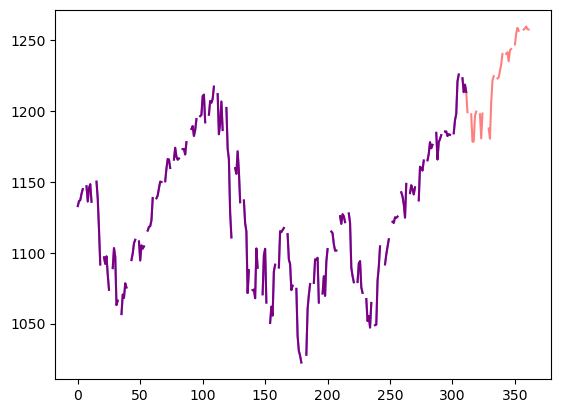

In [753]:
freq = "1D"

train_dataset = Dataset.from_dict(train_dict)
validation_dataset = Dataset.from_dict(validation_dict)
test_dataset = Dataset.from_dict(test_dict)

# assert len(train_dataset[0]['target']) + prediction_length == len(validation_dataset[0]['target'])

import matplotlib.pyplot as plt

figure, axes = plt.subplots()
axes.plot(train_dataset[0]['target'], color="blue")
axes.plot(validation_dataset[0]['target'], color="red", alpha=0.5)

plt.show()


In [754]:
from functools import lru_cache

import pandas as pd
import numpy as np


@lru_cache(10_000)
def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)


def transform_start_field(batch, freq):
    if 'start' in batch.keys():
        batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch


In [755]:
from functools import partial

train_dataset.set_transform(partial(transform_start_field, freq=freq))
test_dataset.set_transform(partial(transform_start_field, freq=freq))

train_dataset[0]


{'start': Period('2010-01-04', 'D'),
 'target': [1132.989990234375,
  1136.52001953125,
  1137.1400146484375,
  1141.68994140625,
  1144.97998046875,
  nan,
  nan,
  1146.97998046875,
  1136.219970703125,
  1145.6800537109375,
  1148.4599609375,
  1136.030029296875,
  nan,
  nan,
  nan,
  1150.22998046875,
  1138.0400390625,
  1116.47998046875,
  1091.760009765625,
  nan,
  nan,
  1096.780029296875,
  1092.1700439453125,
  1097.5,
  1084.530029296875,
  1073.8699951171875,
  nan,
  nan,
  1089.18994140625,
  1103.3199462890625,
  1097.280029296875,
  1063.1099853515625,
  1066.18994140625,
  nan,
  nan,
  1056.739990234375,
  1070.52001953125,
  1068.1300048828125,
  1078.469970703125,
  1075.510009765625,
  nan,
  nan,
  nan,
  1094.8699951171875,
  1099.510009765625,
  1106.75,
  1109.1700439453125,
  nan,
  nan,
  1108.010009765625,
  1094.5999755859375,
  1105.239990234375,
  1102.93994140625,
  1104.489990234375,
  nan,
  nan,
  1115.7099609375,
  1118.31005859375,
  1118.79003906

In [756]:
from gluonts.time_feature import get_lags_for_frequency

# lags_sequence = get_lags_for_frequency(freq)
lags_sequence = [1, 2]
lags_sequence


[1, 2]

In [757]:
from gluonts.time_feature import time_features_from_frequency_str

time_features = time_features_from_frequency_str(freq)

time_features


[<function gluonts.time_feature._base.day_of_week(index: pandas.core.indexes.period.PeriodIndex) -> numpy.ndarray>,
 <function gluonts.time_feature._base.day_of_month(index: pandas.core.indexes.period.PeriodIndex) -> numpy.ndarray>,
 <function gluonts.time_feature._base.day_of_year(index: pandas.core.indexes.period.PeriodIndex) -> numpy.ndarray>]

In [758]:
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction

context_length = 9

config = TimeSeriesTransformerConfig(
    prediction_length=prediction_length,
    context_length=context_length,  # context length
    lags_sequence=lags_sequence,
    num_time_features=len(time_features) + 1,  # we'll add 2 time features ("month of year" and "age", see further)
    num_static_categorical_features=1,  # we have a single static categorical feature, namely time series ID
    cardinality=[len(train_dataset)],  # it has 366 possible values
    embedding_dimension=[2],  # the model will learn an embedding of size 2 for each of the 366 possible values
    encoder_layers=4,
    decoder_layers=4,
)

model = TimeSeriesTransformerForPrediction(config)


## Define Transformations

Next, we define the transformations for the data, in particular for the creation of the time features (based on the dataset or universal ones).

Again, we'll use the GluonTS library for this. We define a `Chain` of transformations (which is a bit comparable to `torchvision.transforms.Compose` for images). It allows us to combine several transformations into a single pipeline.

In [759]:
from gluonts.time_feature import time_features_from_frequency_str, TimeFeature, get_lags_for_frequency
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)


In [760]:
from transformers import PretrainedConfig


def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    # a bit like torchvision.transforms.Compose
    return Chain(
        [
            # step 1: remove static/dynamic fields if not specified
            # RemoveFields(field_names=['Dividends', 'Stock Splits']),

            # step 2: use static features if available, if not add dummy values
            SetField(output_field=FieldName.FEAT_STATIC_CAT, value=[0]),

            SetField(output_field=FieldName.FEAT_STATIC_REAL, value=[0.0]),

            # step 3: convert the data to NumPy (potentially not needed)
            AsNumpyArray(
                field=FieldName.FEAT_STATIC_CAT,
                expected_ndim=1,
                dtype=int,
            ),
            AsNumpyArray(
                field=FieldName.FEAT_STATIC_REAL,
                expected_ndim=1,
            ),
            # AsNumpyArray(
            #     field='open',
            #     # in the following line, we add 1 for the time dimension
            #     expected_ndim=1,
            # ),
            AsNumpyArray(
                field=FieldName.TARGET,
                # in the following line, we add 1 for the time dimension
                expected_ndim=1,
            ),
            # step 4: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),

            # step 5: add temporal features based on freq of the dataset
            # month of year in this case
            # these serve as positional encodings
            # pure time feature, not target info inside
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),

            # step 6: add another temporal feature (just a single number)
            # tells the model where in the life the value of the time series is
            # sort of running counter
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),

            # step 7: vertically stack all the temporal features
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE],
            ),

            # step 8: rename to match HuggingFace names

            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )


In [761]:
from gluonts.transform import target_transformation_length

transformation = create_transformation(freq, config)
transformed_data = transformation.apply(train_dataset, is_train=True)

# b = next(iter(a))

# func = AsNumpyArray(
#     field=FieldName.TARGET,
#     # in the following line, we add 1 for the time dimension
#     expected_ndim=1,
# )
# a = func(train_dataset, is_train=True)

batch = next(iter(transformed_data))
# batch = next(iter(a))
batch.keys()
# batch['time_features']
# batch['observed_mask']
# batch['values']


dict_keys(['start', 'static_categorical_features', 'static_real_features', 'time_features', 'values', 'observed_mask'])

In [762]:
from gluonts.transform.sampler import InstanceSampler
from typing import Optional


def create_instance_splitter(config: PretrainedConfig, mode: str, train_sampler: Optional[InstanceSampler] = None,
                             validation_sampler: Optional[InstanceSampler] = None, ) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler or ValidationSplitSampler(
            min_future=config.prediction_length
        ),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=[
            "time_features",
            "observed_mask",
        ],
    )



In [763]:
from gluonts.itertools import Cyclic

instance_splitter = create_instance_splitter(config, "train")

training_instances = instance_splitter.apply(
    Cyclic(transformed_data)
)

b = next(iter(training_instances))
b


{'start': Period('2010-01-04', 'D'),
 'static_categorical_features': array([0]),
 'static_real_features': array([0.], dtype=float32),
 'past_time_features': array([[ 0.33333334, -0.26666668, -0.1520548 ,  2.1003706 ],
        [ 0.5       , -0.23333333, -0.14931507,  2.1038036 ],
        [-0.5       , -0.2       , -0.14657535,  2.10721   ],
        [-0.33333334, -0.16666667, -0.14383562,  2.1105897 ],
        [-0.16666667, -0.13333334, -0.14109589,  2.1139433 ],
        [ 0.        , -0.1       , -0.13835616,  2.1172712 ],
        [ 0.16666667, -0.06666667, -0.13561644,  2.120574  ],
        [ 0.33333334, -0.03333334, -0.13287671,  2.1238515 ],
        [ 0.5       ,  0.        , -0.13013698,  2.1271048 ],
        [-0.5       ,  0.03333334, -0.12739725,  2.1303337 ],
        [-0.33333334,  0.06666667, -0.12465753,  2.133539  ]],
       dtype=float32),
 'future_time_features': array([[-0.16666667,  0.1       , -0.12191781,  2.1367207 ]],
       dtype=float32),
 'past_observed_mask': array

In [764]:
from gluonts.itertools import Cyclic, IterableSlice, PseudoShuffled
from gluonts.torch.util import IterableDataset
from torch.utils.data import DataLoader

from typing import Iterable


def create_train_dataloader(
        config: PretrainedConfig,
        freq,
        data,
        batch_size: int,
        num_batches_per_epoch: int,
        shuffle_buffer_length: Optional[int] = None,
        **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "static_categorical_features",
        "static_real_features",
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)

    # we initialize a Training instance
    instance_splitter = create_instance_splitter(
        config, "train"
    ) + SelectFields(TRAINING_INPUT_NAMES)

    # the instance splitter will sample a window of
    # context length + lags + prediction length (from the 366 possible transformed time series)
    # randomly from within the target time series and return an iterator.
    training_instances = instance_splitter.apply(
        Cyclic(transformed_data)
        if shuffle_buffer_length is None
        else PseudoShuffled(
            Cyclic(transformed_data),
            shuffle_buffer_length=shuffle_buffer_length,
        )
    )

    # from the training instances iterator we now return a Dataloader which will
    # continue to sample random windows for as long as it is called
    # to return batch_size of the appropriate tensors ready for training!
    return IterableSlice(
        iter(
            DataLoader(
                IterableDataset(training_instances),
                batch_size=batch_size,
                **kwargs,
            )
        ),
        num_batches_per_epoch,
    )



In [765]:
train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=train_dataset,
    batch_size=16,
    num_batches_per_epoch=100,
)

batch = next(iter(train_dataloader))

for k, v in batch.items():
    print("{: >30} {: <30} {: >10}".format(k, str(v.shape), v.type()))

# figure, axes = plt.subplots()
# axes.plot(batch['past_values'][0], color="blue")

# plt.show()
# batch['past_values'][0]


   static_categorical_features torch.Size([16, 1])            torch.LongTensor
          static_real_features torch.Size([16, 1])            torch.FloatTensor
            past_time_features torch.Size([16, 11, 4])        torch.FloatTensor
                   past_values torch.Size([16, 11])           torch.FloatTensor
            past_observed_mask torch.Size([16, 11])           torch.FloatTensor
          future_time_features torch.Size([16, 1, 4])         torch.FloatTensor
                 future_values torch.Size([16, 1])            torch.FloatTensor
          future_observed_mask torch.Size([16, 1])            torch.FloatTensor


In [766]:
def create_test_dataloader(
        config: PretrainedConfig,
        freq,
        data,
        batch_size: int,
        **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "static_categorical_features",
        "static_real_features",
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # we create a Test Instance splitter which will sample the very last
    # context window seen during training only for the encoder.
    instance_sampler = create_instance_splitter(
        config, "validation"
    ) + SelectFields(PREDICTION_INPUT_NAMES)

    # we apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)

    # This returns a Dataloader which will go over the dataset once.
    return DataLoader(IterableDataset(testing_instances), batch_size=batch_size, **kwargs)



In [774]:
transformation = create_transformation(freq, config)
transformed_data = transformation.apply(test_dataset, is_train=False)

instance_sampler = create_instance_splitter(
    config, "validation"
)

testing_instances = instance_sampler.apply(transformed_data, is_train=False)

for i in testing_instances:
    print(i['forecast_start'])


2010-11-11
2010-11-12
2010-11-13
2010-11-14
2010-11-15
2010-11-16
2010-11-17
2010-11-18
2010-11-19
2010-11-20
2010-11-21
2010-11-22
2010-11-23
2010-11-24
2010-11-25
2010-11-26
2010-11-27
2010-11-28
2010-11-29
2010-11-30
2010-12-01
2010-12-02
2010-12-03
2010-12-04
2010-12-05
2010-12-06
2010-12-07
2010-12-08
2010-12-09
2010-12-10
2010-12-11
2010-12-12
2010-12-13
2010-12-14
2010-12-15
2010-12-16
2010-12-17
2010-12-18
2010-12-19
2010-12-20
2010-12-21
2010-12-22
2010-12-23
2010-12-24
2010-12-25
2010-12-26
2010-12-27
2010-12-28
2010-12-29
2010-12-30


dict_keys(['start', 'static_categorical_features', 'static_real_features', 'past_time_features', 'future_time_features', 'past_observed_mask', 'future_observed_mask', 'past_values', 'future_values', 'past_is_pad', 'forecast_start'])

In [768]:
train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=train_dataset,
    batch_size=16,
    num_batches_per_epoch=100,
)

# TODO test dataset has only one data now.
test_dataloader = create_test_dataloader(
    config=config,
    freq=freq,
    data=test_dataset,
    batch_size=64,
)

train_dataloader


In [769]:
batch = next(iter(test_dataloader))

# print(batch['future_time_features'])

for k, v in batch.items():
    print("{: >30} {: <30} {: >10}".format(k, str(v.shape), v.type()))
    # print(k, v.shape, v.type(), sep='\t')

batch


   static_categorical_features torch.Size([50, 1])            torch.LongTensor
          static_real_features torch.Size([50, 1])            torch.FloatTensor
            past_time_features torch.Size([50, 11, 4])        torch.FloatTensor
                   past_values torch.Size([50, 11])           torch.FloatTensor
            past_observed_mask torch.Size([50, 11])           torch.FloatTensor
          future_time_features torch.Size([50, 1, 4])         torch.FloatTensor


{'static_categorical_features': tensor([[0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0]]),
 'static_real_features': tensor([[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
   

In [770]:
batch = next(iter(train_dataloader))

for k, v in batch.items():
    print("{: >30} {: <30} {: >10}".format(k, str(v.shape), v.type()))


   static_categorical_features torch.Size([16, 1])            torch.LongTensor
          static_real_features torch.Size([16, 1])            torch.FloatTensor
            past_time_features torch.Size([16, 11, 4])        torch.FloatTensor
                   past_values torch.Size([16, 11])           torch.FloatTensor
            past_observed_mask torch.Size([16, 11])           torch.FloatTensor
          future_time_features torch.Size([16, 1, 4])         torch.FloatTensor
                 future_values torch.Size([16, 1])            torch.FloatTensor
          future_observed_mask torch.Size([16, 1])            torch.FloatTensor


In [771]:
outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"],
    static_real_features=batch["static_real_features"],
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"],
    future_observed_mask=batch["future_observed_mask"],
    output_hidden_states=True
)

outputs


Seq2SeqTimeSeriesPredictionOutput(loss=tensor(8.5350, grad_fn=<DivBackward0>), params=(tensor([[2.9510],
        [2.9581],
        [2.9469],
        [2.9521],
        [2.9453],
        [2.9447],
        [2.9576],
        [2.9565],
        [2.9526],
        [2.9463],
        [2.9485],
        [2.9477],
        [2.9477],
        [2.9534],
        [2.9507],
        [2.9489]], grad_fn=<SqueezeBackward1>), tensor([[0.0854],
        [0.0794],
        [0.0694],
        [0.0639],
        [0.0860],
        [0.0806],
        [0.0655],
        [0.0652],
        [0.0817],
        [0.0722],
        [0.0825],
        [0.0869],
        [0.0839],
        [0.0690],
        [0.0865],
        [0.0800]], grad_fn=<SqueezeBackward1>), tensor([[1.0528],
        [1.0521],
        [1.0580],
        [1.0493],
        [1.0340],
        [1.0402],
        [1.0569],
        [1.0524],
        [1.0367],
        [1.0284],
        [1.0504],
        [1.0439],
        [1.0481],
        [1.0542],
        [1.0508],
       

In [772]:
print("Loss:", outputs.loss.item())


Loss: 8.534956932067871


In [773]:
from accelerate import Accelerator
from torch.optim import Adam
from tqdm import tqdm

accelerator = Accelerator()
device = accelerator.device

model.to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

model, optimizer, train_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader,
)

model.train()
for epoch in tqdm(range(40)):
    for batch in train_dataloader:
        optimizer.zero_grad()
        outputs = model(
            static_categorical_features=batch["static_categorical_features"].to(device),
            static_real_features=batch["static_real_features"].to(device),
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            future_values=batch["future_values"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
            future_observed_mask=batch["future_observed_mask"].to(device),
        )
        loss = outputs.loss

        # Backpropagation
        accelerator.backward(loss)
        optimizer.step()

        # print(loss.item())



 42%|████▎     | 17/40 [00:33<00:44,  1.95s/it]


KeyboardInterrupt: 

In [ ]:
import torch

torch.save(model.state_dict(), 'weight/test.pt')


In [860]:
model.eval()

forecasts = []

for batch in test_dataloader:
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device),
        static_real_features=batch["static_real_features"].to(device),
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts.append(outputs.sequences.cpu().numpy())

forecasts = np.vstack(forecasts)
forecasts.shape


(50, 100, 1)

In [864]:
forecast_median = np.median(forecasts, 1)
forecast_median = (forecast_median - dataset_mean) / dataset_std

# np.median(forecasts[0][0])
# forecast_median.shape
forecast_median

# forecasts.shape
# forecasts[:, 0, :, 0]
# np.median(forecasts[:, 0])


array([[1.8667784],
       [1.7907977],
       [2.066187 ],
       [2.0307493],
       [1.9750068],
       [1.6973935],
       [1.9570929],
       [1.5754195],
       [1.6412709],
       [1.5954214],
       [1.4748036],
       [1.2990261],
       [1.6487832],
       [1.2279764],
       [1.3656814],
       [1.5475559],
       [1.470499 ],
       [1.2713115],
       [1.6169156],
       [1.3645769],
       [1.2346258],
       [1.2782408],
       [1.5044906],
       [1.7385634],
       [1.7372382],
       [1.8678725],
       [1.831477 ],
       [1.7408698],
       [2.0128484],
       [2.1567197],
       [2.2652178],
       [2.2723267],
       [2.266258 ],
       [2.461272 ],
       [2.436755 ],
       [2.5879638],
       [2.2913733],
       [2.5388887],
       [2.589808 ],
       [2.5145926],
       [2.5934343],
       [2.5641558],
       [2.5438404],
       [2.6444564],
       [2.7404802],
       [2.5928643],
       [2.6513062],
       [3.0502641],
       [2.9214842],
       [2.949006 ]],

In [ ]:
from evaluate import load
from gluonts.time_feature import get_seasonality

mase_metric = load("evaluate-metric/mase")
smape_metric = load("evaluate-metric/smape")

mae_metric = load("evaluate-metric/mae")
mse_metric = load("evaluate-metric/mse")
mape_metric = load("evaluate-metric/mape")


In [919]:
ground_truth = np.array(test_dict['target'][-1][-split_size:])
ground_truth = (ground_truth - dataset_mean) / dataset_std

is_finite = np.isfinite(ground_truth)

predictions = forecast_median[is_finite][:, 0]
references = ground_truth[is_finite]

mae = mae_metric.compute(
    predictions=predictions,
    references=references,
)
mae_metrics = mae["mae"]

mse = mse_metric.compute(
    predictions=predictions,
    references=references,
    squared=False,
)
mse_metrics = mse["mse"]

mape = mape_metric.compute(
    predictions=predictions,
    references=references,
)
mape_metrics = mape["mape"]


In [986]:
print(f"MAE: {mae_metrics}")
print(f"RMSE: {mse_metrics}")
print(f"MAPE: {mape_metrics}")


MAE: 0.265985180349911
RMSE: 0.33065042097161224
MAPE: 0.16505945905766978


[Period('2010-01-04', 'D'),
 Period('2010-01-04', 'D'),
 Period('2010-01-04', 'D'),
 Period('2010-01-04', 'D'),
 Period('2010-01-04', 'D'),
 Period('2010-01-04', 'D'),
 Period('2010-01-04', 'D'),
 Period('2010-01-04', 'D'),
 Period('2010-01-04', 'D'),
 Period('2010-01-04', 'D'),
 Period('2010-01-04', 'D'),
 Period('2010-01-04', 'D'),
 Period('2010-01-04', 'D'),
 Period('2010-01-04', 'D'),
 Period('2010-01-04', 'D'),
 Period('2010-01-04', 'D'),
 Period('2010-01-04', 'D'),
 Period('2010-01-04', 'D'),
 Period('2010-01-04', 'D'),
 Period('2010-01-04', 'D'),
 Period('2010-01-04', 'D'),
 Period('2010-01-04', 'D'),
 Period('2010-01-04', 'D'),
 Period('2010-01-04', 'D'),
 Period('2010-01-04', 'D'),
 Period('2010-01-04', 'D'),
 Period('2010-01-04', 'D'),
 Period('2010-01-04', 'D'),
 Period('2010-01-04', 'D'),
 Period('2010-01-04', 'D'),
 Period('2010-01-04', 'D'),
 Period('2010-01-04', 'D'),
 Period('2010-01-04', 'D'),
 Period('2010-01-04', 'D'),
 Period('2010-01-04', 'D'),
 Period('2010-01-04'

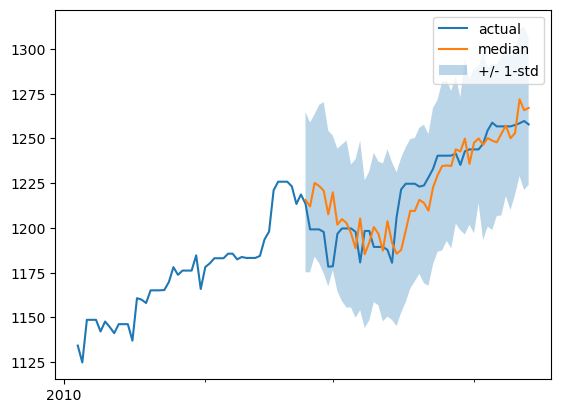

In [988]:
import matplotlib.dates as mdates

fig, ax = plt.subplots()

display_size = split_size * 2
actual_value = test_dataset[FieldName.TARGET][-1][-display_size:]

df_actual_value = pd.DataFrame(actual_value)
df_actual_value = df_actual_value.fillna(method='ffill')

index = pd.period_range(
    start=test_dataset[FieldName.START][0],
    periods=len(actual_value),
    freq=freq,
).to_timestamp()

# Major ticks every half year, minor ticks every month,
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 13)))
ax.xaxis.set_minor_locator(mdates.MonthLocator())

ax.plot(
    index,
    df_actual_value,
    label="actual",
)

plt.plot(
    index[-split_size:],
    np.median(forecasts, axis=1),
    label="median",
)

forecasts_mean = np.mean(forecasts, axis=1)[:, 0]
forecasts_std = np.std(forecasts, axis=1)[:, 0]

plt.fill_between(
    index[-split_size:],
    forecasts_mean - forecasts_std,
    forecasts_mean + forecasts_std,
    alpha=0.3,
    interpolate=True,
    label="+/- 1-std",
)

plt.legend()
plt.show()



ValueError: Value must be Period, string, integer, or datetime

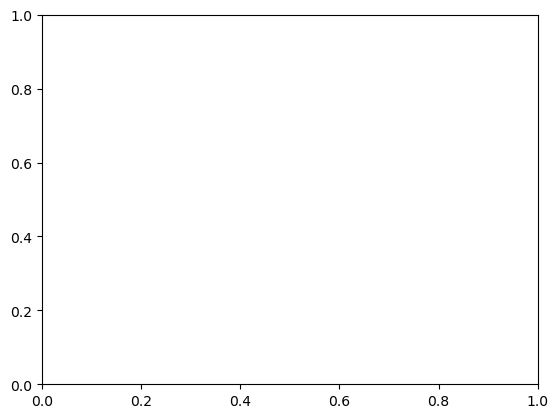

In [925]:

# Major ticks every half year, minor ticks every month,
# ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
# ax.xaxis.set_minor_locator(mdates.MonthLocator())
#
# ax.plot(
#     index[-2 * prediction_length:],
#     test_dataset[ts_index]["target"][-2 * prediction_length:],
#     label="actual",
# )
#
# plt.plot(
#     index[-prediction_length:],
#     np.median(forecasts[ts_index], axis=0),
#     label="median",
# )
#
# plt.fill_between(
#     index[-prediction_length:],
#     forecasts[ts_index].mean(0) - forecasts[ts_index].std(axis=0),
#     forecasts[ts_index].mean(0) + forecasts[ts_index].std(axis=0),
#     alpha=0.3,
#     interpolate=True,
#     label="+/- 1-std",
# )
# plt.legend()
# plt.show()
